## Thoughts on Classifying Multisets with Similarity
_by Alex Morgan_

Let's imagine a simplified world. I make these simplifications just to show clearly the idea I have in mind. Translating this to the more complex world we actually live in should not be insurmountable.

Let's imagine that:
* all cdr3 regions are exactly 3 amino acids long
* Disease X is characterized by one epitope
* The motif AM_ is good for binding that epitope, so patients with disease X tend to have cdr3s matching that

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

Let's suppose we have these samples with metadata:

In [3]:
patients = pd.DataFrame(
    {
        "id": ["S01", "S02", "S03", "S04"],
        "has_X": [True, True, False, False],
    }
)
patients

,id,has_X
0,S01,True
1,S02,True
2,S03,False
3,S04,False


And this sequencing data:

In [4]:
seq_dataset = {}
seq_dataset["S01"] = pd.DataFrame(
    {
        "cdr3_AA" : ["LLK", "AMN", "AMN"],
        "UMI" :["A", "G", "C"],
    }
)
seq_dataset["S02"] = pd.DataFrame(
    {
        "cdr3_AA" : ["AMP", "FVW", "AMM"],
        "UMI" :["C", "T", "C"],
    }
)
seq_dataset["S03"] = pd.DataFrame(
    {
        "cdr3_AA" : ["SPP", "LLK", "KNF"],
        "UMI" :["T", "G", "A"],
    }
)
seq_dataset["S04"] = pd.DataFrame(
    {
        "cdr3_AA" : ["SIP", "YVW", "IVW"],
        "UMI" :["C", "C", "T"],
    }
)
for sampleID, df in seq_dataset.items():
    print(sampleID)
    print(df)
    print()

S01
  cdr3_AA UMI
0     LLK   A
1     AMN   G
2     AMN   C

S02
  cdr3_AA UMI
0     AMP   C
1     FVW   T
2     AMM   C

S03
  cdr3_AA UMI
0     SPP   T
1     LLK   G
2     KNF   A

S04
  cdr3_AA UMI
0     SIP   C
1     YVW   C
2     IVW   T



In [5]:
def df_with_id(df, sampleID):
    df['id'] = sampleID
    return df
df = pd.concat([df_with_id(df, key) for key, df in seq_dataset.items()])
df

,cdr3_AA,UMI,id
0,LLK,A,S01
1,AMN,G,S01
2,AMN,C,S01
0,AMP,C,S02
1,FVW,T,S02
2,AMM,C,S02
0,SPP,T,S03
1,LLK,G,S03
2,KNF,A,S03
0,SIP,C,S04


Here's a summary of how many cells we see with each sequence in each sample:

In [6]:
combined_df = df.groupby(['cdr3_AA', 'id']).count().reset_index()
meta = pd.pivot_table(combined_df, values=['UMI'], index=['cdr3_AA'], columns=['id'], aggfunc="sum").fillna(0)
meta

UMI               
id       S01  S02  S03  S04
cdr3_AA                    
AMM      0.0  1.0  0.0  0.0
AMN      2.0  0.0  0.0  0.0
AMP      0.0  1.0  0.0  0.0
FVW      0.0  1.0  0.0  0.0
IVW      0.0  0.0  0.0  1.0
KNF      0.0  0.0  1.0  0.0
LLK      1.0  0.0  1.0  0.0
SIP      0.0  0.0  0.0  1.0
SPP      0.0  0.0  1.0  0.0
YVW      0.0  0.0  0.0  1.0

As you can see by inspection, no two patients have any overlapping sequences in our dataset, _except_ for LLK which is not useful for distinguishing disease X vs. not disease X.

However, let's define similarity (in an overly-simple way that works in our overly-simple world). Then we can discern some similarity between differing sequences in different patients.

In [7]:
def hamming(seq1, seq2):
    """
    Calculate identical proportion beween two sequences. 
    Important: Assumes that sequences are always the same length!
    """
    total = 0
    same = 0
    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            same += 1
        total += 1
    return same / total

Then we can calculate a Z, a similarity matrix between all pairs of sequences:

In [8]:
# S is the number of distinct sequences ("species")
S = meta.shape[0]
sorted_seq = meta.index
Z = np.zeros(shape=(S, S))
for i in range(S):
    for j in range(S):
        Z[i][j] = hamming(sorted_seq[i], sorted_seq[j])

In [9]:
# Displaying Z as a dataframe, so it's easy to inspect:
pd.DataFrame(Z, index=list(sorted_seq), columns=list(sorted_seq))

,AMM,AMN,AMP,FVW,IVW,KNF,LLK,SIP,SPP,YVW
AMM,1.000000,0.666667,0.666667,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
AMN,0.666667,1.000000,0.666667,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
AMP,0.666667,0.666667,1.000000,0.000000,0.000000,0.0,0.0,0.333333,0.333333,0.000000
FVW,0.000000,0.000000,0.000000,1.000000,0.666667,0.0,0.0,0.000000,0.000000,0.666667
IVW,0.000000,0.000000,0.000000,0.666667,1.000000,0.0,0.0,0.000000,0.000000,0.666667
KNF,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000
LLK,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000
SIP,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.0,1.000000,0.666667,0.000000
SPP,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.0,0.666667,1.000000,0.000000
YVW,0.000000,0.000000,0.000000,0.666667,0.666667,0.0,0.0,0.000000,0.000000,1.000000


Premultiply the nomalized counts by Z:

In [10]:
counts = np.array(meta)
norm_counts =counts / counts.sum(0)
ordinariness = Z @ norm_counts
results = pd.DataFrame(ordinariness, columns=list(patients['id']), 
             index=["Ordinariness of %s" % x for x in sorted_seq])
results

,S01,S02,S03,S04
Ordinariness of AMM,0.444444,0.555556,0.000000,0.000000
Ordinariness of AMN,0.666667,0.444444,0.000000,0.000000
Ordinariness of AMP,0.444444,0.555556,0.111111,0.111111
Ordinariness of FVW,0.000000,0.333333,0.000000,0.444444
Ordinariness of IVW,0.000000,0.222222,0.000000,0.555556
Ordinariness of KNF,0.000000,0.000000,0.333333,0.000000
Ordinariness of LLK,0.333333,0.000000,0.333333,0.000000
Ordinariness of SIP,0.000000,0.111111,0.222222,0.333333
Ordinariness of SPP,0.000000,0.111111,0.333333,0.222222
Ordinariness of YVW,0.000000,0.222222,0.000000,0.555556


### Parenthetical

If you've read Leinster & Cobbald's paper and/or Reeve's paper and/or the `greylock` code you might think "oh this math! I've seen this math before. We are calculating diversity!"

That's not where this notebook is going. We could calculate effective species counts for all values of q, and $\beta$ and $\rho$ and all that. But I don't have a theory as to why those would be particularly useful. So, we are going to calculate the same $Zp$ vectors, but for a different purpose.

Each value in this resulting matrix is, in Leinster & Cobbald's words, "the relative abundance of species similar to the $i$th". For example, sample S01 does not contain the sequence AMM (that we detected). However, it does contain sequence(s) similar to AMM, thus the non-zero value of "Ordinariness of AMM" in the S01 Zp. 

These make really good features! 

_Features!!!_

## _FEATURES!!!_

With features, we can do machine learning.

In [11]:
m = results.T.join(patients.set_index("id"))
m["color"] = "blue"
m.loc[m["has_X"], "color"] = "red"
m

,Ordinariness of AMM,Ordinariness of AMN,Ordinariness of AMP,Ordinariness of FVW,Ordinariness of IVW,Ordinariness of KNF,Ordinariness of LLK,Ordinariness of SIP,Ordinariness of SPP,Ordinariness of YVW,has_X,color
S01,0.444444,0.666667,0.444444,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,True,red
S02,0.555556,0.444444,0.555556,0.333333,0.222222,0.000000,0.000000,0.111111,0.111111,0.222222,True,red
S03,0.000000,0.000000,0.111111,0.000000,0.000000,0.333333,0.333333,0.222222,0.333333,0.000000,False,blue
S04,0.000000,0.000000,0.111111,0.444444,0.555556,0.000000,0.000000,0.333333,0.222222,0.555556,False,blue


In [12]:
def show_features(f1, f2):
    fig, ax = plt.subplots()
    ax.scatter(m["Ordinariness of %s" % f1], m["Ordinariness of %s" % f2], c=m["color"])
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    fig.show()

<IPython.core.display.Javascript object>


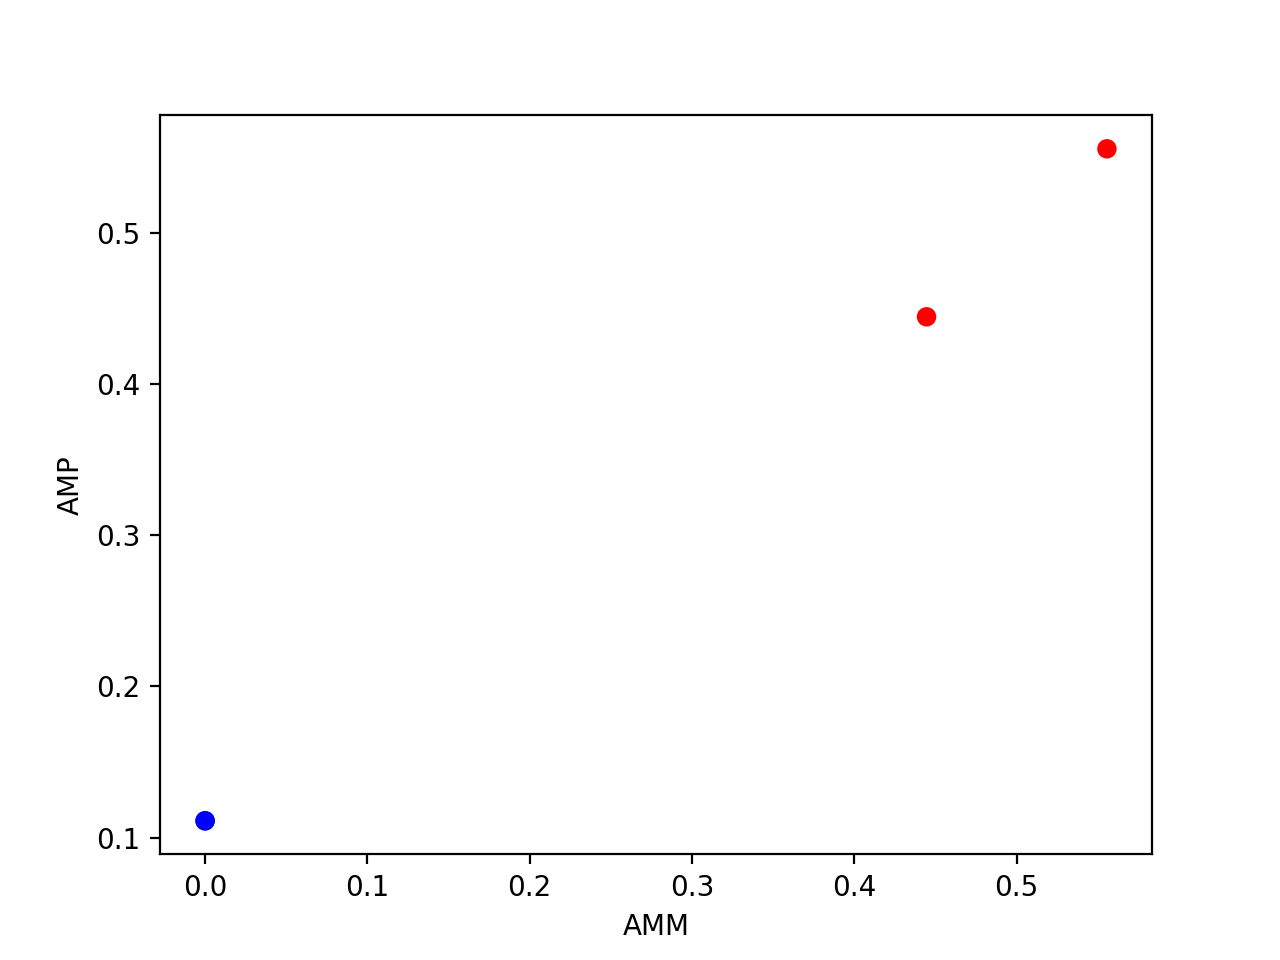

In [13]:
show_features("AMM", "AMP")

Other features are less useful, or only spuriously useful:

<IPython.core.display.Javascript object>


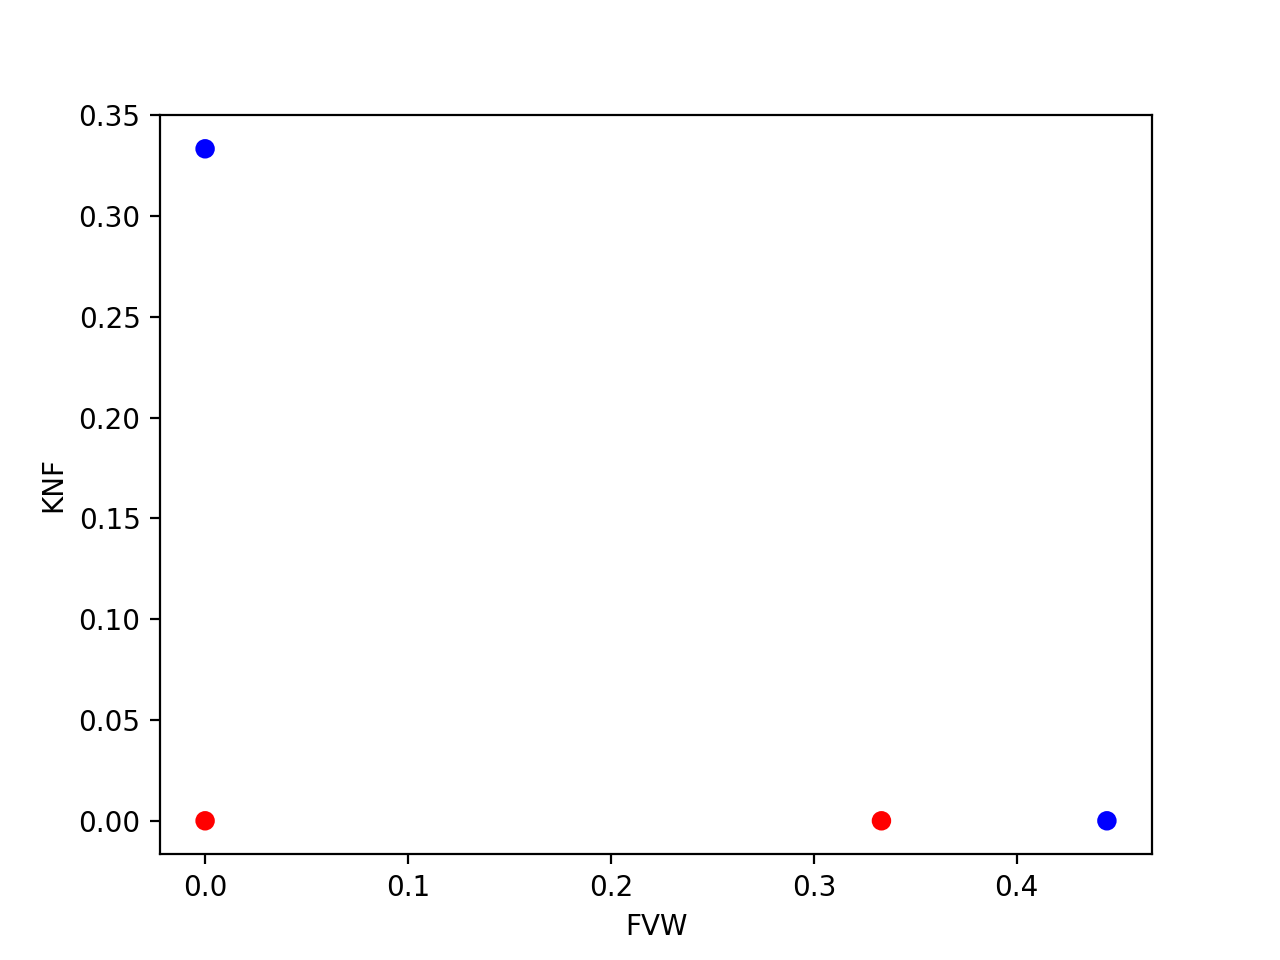

In [14]:
show_features("FVW", "KNF")

A next step would be to apply a statistical test to throw out the features that are not significantly
different between the disease_X and not_disease_X samples. There will still be more features than we want, because of redundancy-- "Ordinariness of AMM" and "Ordinariness of AMN" encode much of the same information. PCA for dimensionality reduction?

Of course, this toy example is vastly simpler than the real world:
* cdr3 sequences vary in length, and thus Hamming is a terrible measure of similarity
* The actual datasets are so large that if we tried to run this exact code, Z would not fit in RAM
* Calculating Z is $O(n_2)$, so we need a fast implementation (and probably some shortcuts) to calculate it within a reasonable amount of time.

All of these difficulties are tractable:

There are many ways to calculate similarity between sequences. Gold standard truth is binding, but this is slow and difficult to determine. Structure is a proxy for binding, but too slow to calculate for all sequences. Levenstein distance is related to structure, but still too slow for the full dataset. Calculating an embedding for each sequence, and then calculating similarity as related to some type of distance between embedding vectors, would be reasonably fast. Calculating similarity from distance between k-mer vectors is blazingly fast, but probably the least informative. This is the meat of the project: looking at trade-offs between speed and accuracy in various similarity calculations.

To address the problem of the _size_ of the datasets, I've been experimenting with creating Z in chunks, and calculatations using sparse matrices to create the Zp vectors in pieces.

Thus, we should be able to scale up from this toy example to the real problem.